# Introduction

Paralegals navigate an overwhelming number of documents and past cases to find information strengthening their argument. Their responsibilities of conducting research and organizing facts can be streamlined using a combination of question answering (QA) and sentiment analysis.

[Project Workflow](https://drive.google.com/file/d/17SBYihxCSsiTUQqeIgyEdN30pzHwtLy6/view?usp=sharing)

# Imports / Installs

In [ ]:
# Installations
!pip install requests beautifulsoup4 nltk matplotlib

!pip install scikit-learn matplotlib pandas

!pip install symspellpy

# Import libraries
from symspellpy import SymSpell, Verbosity
import requests, re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

# Data Ingestion

## Web Scraper Function

In [ ]:
# Returns raw text of website. Requires URL argument (str).
def web_scrape(URL):
  response = requests.get(URL)
  soup = BeautifulSoup(response.text, 'html.parser')
  raw_text = soup.get_text(separator=" ", strip=True)
  return raw_text

In [ ]:
# Step 1: Scrape data from Gun Rights section of Justia
gun_raw_text = web_scrape('https://supreme.justia.com/cases-by-topic/gun-rights/')
print(gun_raw_text)

Gun Rights Supreme Court Cases | Justia U.S. Supreme Court Center Log In Sign Up Find a Lawyer Ask a Lawyer Research the Law Law Schools Laws & Regs Newsletters Marketing Solutions Justia Connect Pro Membership Practice Membership Public Membership Justia Lawyer Directory Platinum Placements Gold Placements Justia Elevate SEO Websites Blogs Justia Amplify PPC Management Google Business Profile Social Media Justia Onward Blog Justia › U.S. Law › U.S. Case Law › U.S. Supreme Court › Cases By Topic › Gun Rights Gun Rights Supreme Court Cases As gun violence surges across America, the Second Amendment has become one of the most contested provisions of the U.S. Constitution. Its full text states that “a well regulated militia being necessary to the security of a free state, the right of the people to keep and bear arms shall not be infringed.” For most of its history, the Supreme Court addressed the Second Amendment only occasionally and in relatively narrow circumstances. This changed in 2

In [ ]:
# Step 1: Scraped data from Climate Change section of Justia
climate_raw_text  = web_scrape('https://supreme.justia.com/cases-by-topic/climate-change-environment/')

In [ ]:
# Step 1: Scraped data from Criminal Trials & Prosecution
criminal_trals_raw_text = web_scrape('https://supreme.justia.com/cases-by-topic/criminal-trials/')

In [ ]:
# Step 1: Scrapped data from Death Penalty
dp_raw_text = web_scrape('https://supreme.justia.com/cases-by-topic/death-penalty-criminal-sentencing/')

## Kaggle Dataset
Link to [Dataset](https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction/data)
Name: justice.csv

In [ ]:
# Read CSV. Convert to Pandas DataFrame
df = pd.read_csv('data/justice.csv')
# Remove rows with missing data
df.dropna(inplace=True)
# Print first 5 rows
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [ ]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party',
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [ ]:
df.head()

,facts,first_party_winner,decision_type,disposition,issue_area
1,<p>Joan Stanley had three children with Peter ...,True,majority opinion,reversed/remanded,Civil Rights
2,<p>John Giglio was convicted of passing forged...,True,majority opinion,reversed/remanded,Due Process
3,"<p>The Idaho Probate Code specified that ""male...",True,majority opinion,reversed/remanded,Civil Rights
4,"<p>Miller, after conducting a mass mailing cam...",True,majority opinion,vacated/remanded,First Amendment
5,<p>Ernest E. Mandel was a Belgian professional...,True,majority opinion,reversed,First Amendment


# Data Preprocessing

## Data Prep Function

In [ ]:
import os.path
# Download and Load the SymSpell Dict

!wget -q https://github.com/mammothb/symspellpy/raw/master/symspellpy/frequency_dictionary_en_82_765.txt
# Initialize SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "/content/frequency_dictionary_en_82_765.txt"

# Check if dictionary path exists already, delete before creating
if os.path.exists(dictionary_path):
  !rm -f /content/frequency_dictionary_en_82_765.txt
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Returns cleaned text. Requires raw text (str) arg. Optional start (int), end (int) args.
def data_preprocessor(raw_text, start=None, end=None):

    # Clean text: Remove punctuations, all lowercase, strip(), remove any numbers
    cleaned_text = re.sub(r'[^\w\s]|\d+', '', str(raw_text).lower().strip())

    # Correct Spelling
    correction = sym_spell.lookup_compound(cleaned_text, max_edit_distance=2)
    corrected_text = correction[0].term if correction else cleaned_text # Extract only the corrected term.


    # Step 2: Tokenize text
    tokens = word_tokenize(corrected_text) #

    # Step 3: Remove stopwords (After spell correction)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Step 4: Join all tokens into one string.
    final_text = ' '.join(filtered_tokens[start:end]) # Filter out unnecessary web info.

    return final_text

In [ ]:
# Clean Gun Rights raw text data
cleaned_gun_text = data_preprocessor(gun_raw_text, 75, 498)
print(cleaned_gun_text)

sample_text = "Ths is a smeple txt wth speling erors."

corrected_text = data_preprocessor(sample_text)
print("Original Text: ", sample_text)
print("Corrected Text: ",  corrected_text)

gun violence surges across america second amendment become one contested provisions us constitution full text states well regulated militia necessary security free state right people keep bear arms shall infringed history supreme court addressed second amendment occasionally relatively narrow circumstances changed court reviewed challenge handgun ban district columbia writing majority opinion district columbia heller justice antonio scalia rejected argument second amendment protects right possess carry firearm connection militia service instead scalia found second amendment supports individual right possess guns use traditionally lawful purposes series supreme court decisions since heller reaffirmed broad understanding gun rights constitution result legislatures seeking pass gun control measures public safety purposes seen options shrink sharply selection supreme court cases involving gun rights arranged newest oldest united states brahmi author john roberts individual found court pose

In [ ]:
# Clean Climate Change raw text data
cleaned_cc_text = data_preprocessor(climate_raw_text, 75, 498)
print(cleaned_cc_text)

supreme court cases climate change environmental problems extend well beyond state even national borders thus federal government holds primary responsibility area although directly compel states enact enforce federal regulatory programs notable federal statutes affecting environment include clean water act controls water pollution clean air act controls air pollution comprehensive environmental response compensation liability act cercla governs cleanup sites contaminated hazardous substances national environmental policy act requires federal agencies assess environmental impact proposed actions endangered species act aims conserve threatened endangered plants animals habitats environmental protection agency main government agency field environmental law cases often require supreme court interpret federal statutes review actions epa agencies constitutional questions may arise occasionally since environmental protection relatively modern concern environmental law cases arisen last half c

In [ ]:
# Clean Death Penalty raw text data
cleaned_dp_text = data_preprocessor(dp_raw_text, 75, 498) # Process raw text
cleaned_dp_tokens = cleaned_dp_text.split() # Split into tokens
print(cleaned_dp_text)

penalty criminal sentencing supreme court cases eighth amendment us constitution prohibits imposition cruel unusual punishment supreme court often considers eighth amendment principles context death penalty remains effect many states federal level however three strikes laws certain sentencing provisions may trigger eighth amendment scrutiny well supreme court emphasized sentence need strictly proportionate crime meet constitutional requirements meanwhile limited capital punishment narrow range crimes forbidden imposition certain types defendants selection supreme court cases involving death penalty criminal sentencing arranged newest oldest jones v mississippi author brett kavanaugh sentencer need make separate factual finding permanent incorrigibility sentencing murderer life without parole bucklew v precythe author neil gorsuch establish states chosen method cruelly superadds pain death sentence prisoner must show feasible readily implemented alternative method would significantly re

In [ ]:
# Clean Criminal Trials and Prosecution raw text data
cleaned_ctp_text = data_preprocessor(criminal_trals_raw_text, 75, 498)
cleaned_ctp_tokens = cleaned_ctp_text.split()
print(cleaned_ctp_text)

justia opinion summary newsletters explore additional available newsletters sign free summaries get latest delivered directly suggestions enter email webinars justia webinars open lawyers nonlawyers lawyers please visit individual webinar pages information cle accreditation ask lawyer get free answers legal question get free answers experienced lawyers ask question find lawyer lawyers get listed get free directory profile listing justia legal resources find lawyer bankruptcy lawyers business lawyers criminal lawyers employment lawyers estate planning lawyers family lawyers personal injury lawyers individuals bankruptcy criminal divorce dui estate planning family law personal injury business business formation business operations employment intellectual property international trade real estate tax law law schools dictionary admissions financial aid course outlines law journals blogs employment us federal law us constitution us code regulations supreme court circuit courts district court

## Kaggle Preprocessing

In [ ]:
# Take out facts column for preprocessing
df_nlp = df['facts']
# df_nlp is a Series (1D) so change to Pandas DataFrame (2D)
df_nlp = pd.DataFrame(df_nlp, columns=['facts'])

In [ ]:
# Remove HTML tags
df_nlp['facts'] = df_nlp['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp.head()

,facts
1,Joan Stanley had three children with Peter Sta...
2,John Giglio was convicted of passing forged mo...
3,"The Idaho Probate Code specified that ""males m..."
4,"Miller, after conducting a mass mailing campai..."
5,Ernest E. Mandel was a Belgian professional jo...


In [ ]:
# Corpus is a Series to be able to tokenize
corpus = df_nlp['facts']
# corpus.str.cat(sep =' ') gets every word instead of stopping at ... for each row
fact_tokens = word_tokenize(corpus.str.cat(sep=' '))
print(fact_tokens)

In [ ]:
# Apply preprocessing steps to facts column
df_nlp['clean_facts'] = df_nlp['facts'].apply(lambda x: data_preprocessor(x))

In [ ]:
df_nlp.head()

,facts,clean_facts
1,Joan Stanley had three children with Peter Sta...,joan stanley three children peter stanley stan...
2,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
3,"The Idaho Probate Code specified that ""males m...",idaho probate code specified males must prefer...
4,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
5,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...


# Lemmatization

In [ ]:
# Convert from string to list before lemmatization
cleaned_gun_tokens = cleaned_gun_text.split()
cleaned_dp_tokens = cleaned_dp_text.split()
cleaned_cc_tokens = cleaned_cc_text.split()

In [ ]:
from nltk.corpus import stopwords # Already imported earlier but safer to reimport
stop_words = set(stopwords.words('english'))

lem = WordNetLemmatizer()

# Function to map POS tags to WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'a'  # Adjective


# Function to lemmatize a tokenized dataset
def lemmatize_tokens(token_list):
    tagged_tokens = pos_tag(token_list)  # Apply POS tagging
    lemmatized_tokens = [
        lem.lemmatize(token, get_wordnet_pos(tag))
        for token, tag in tagged_tokens if token not in stop_words and len(token) > 1
    ]
    return ' '.join(lemmatized_tokens)  # Convert list back to a string

In [ ]:
# Team members would replace with their tokens here
final_gun_tokens = lemmatize_tokens(cleaned_gun_tokens)
final_dp_tokens = lemmatize_tokens(cleaned_dp_tokens)
final_cc_tokens = lemmatize_tokens(cleaned_cc_tokens)

print(final_gun_tokens)
print(final_dp_tokens)
print(final_cc_tokens)

# TF-IDF model


Top 10 important words in the combined dataset:
amendment    0.416814
author       0.400783
state        0.272533
second       0.192376
eighth       0.192376
court        0.176345
right        0.176345
sentence     0.144282
crime        0.128251
arm          0.112219
Name: 0, dtype: float64


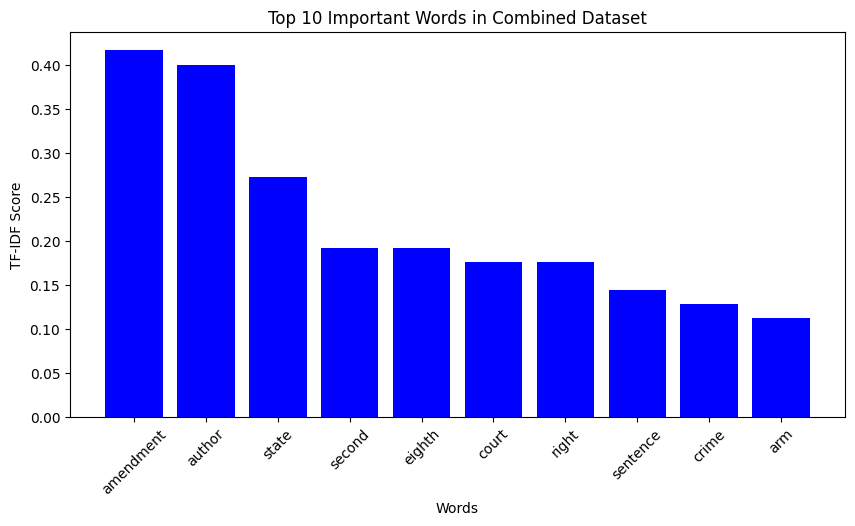

In [ ]:
!pip install scikit-learn matplotlib pandas

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_tfidf_combined(text_data_list):
    combined_text = " ".join(text_data_list)  # Combine all tokenized text
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([combined_text])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Display the top 10 words for the combined dataset
    print("\nTop 10 important words in the combined dataset:")
    top_words = tfidf_df.iloc[0].sort_values(ascending=False).head(10)
    print(top_words)

    # Plot top words for the combined dataset
    plt.figure(figsize=(10, 5))
    plt.bar(top_words.index, top_words.values, color='blue')
    plt.xlabel("Words")
    plt.ylabel("TF-IDF Score")
    plt.title("Top 10 Important Words in Combined Dataset")
    plt.xticks(rotation=45)
    plt.show()

    return tfidf_df, vectorizer

# TF_IDF for gun tokens and death penalty
total_combined_tokens = [final_gun_tokens, final_dp_tokens]  # Team members add more as needed

# Run TF-IDF on the combined dataset
tfidf_df, vectorizer = apply_tfidf_combined(total_combined_tokens)


# MongoDB

*   Insert Kaggle dataset cases into DB ✅
*   Insert web scraped data ✅

Goal: Allow us to query for k most relevant documents.

### Code

In [ ]:
!python -m pip install "pymongo[srv]"

In [ ]:
# Imports
import pymongo
import pandas as pd
import json
from sentence_transformers import SentenceTransformer

#### Connecting to MongoDB Cluster

In [ ]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = "mongodb+srv://CONNECTION_URI_STRING"

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


#### Prepping Kaggle dataset for DB ingestion

In [ ]:
# Drop the facts column to store only cleaned facts in DB
df_nlp.drop(columns=['facts'], inplace=True)
# Print our data one more time
df_nlp.head()

,clean_facts
1,joan stanley three children peter stanley stan...
2,john giglio convicted passing forged money ord...
3,idaho probate code specified males must prefer...
4,miller conducting mass mailing campaign advert...
5,ernest e mandel belgian professional journalis...


In [ ]:
# Convert CSV to Key-Value pairs
data = df_nlp.to_dict(orient='records')

In [ ]:
# Show 2 records of converted data
for i in range(2):
  print(data[i])

{'clean_facts': 'joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried'}
{'clean_facts': 'john giglio convicted passing forged money orders appeal us court appeals second circuit pending giglios counsel discovered new evidence evidence indicated prosecution failed disclose promised key witness immunity prosecution exchange testimony giglio district court denied giglios motion new trial finding error affect verdict court appeals affirmed'}


#### Database Ingestion Part 1: Kaggle

In [ ]:
# Check if DB already exists, else create. Makes sure we don't re-create DB when executing cell.
if 'Cases' in client.list_database_names():
  print("Database already exists")
else:
  # Create one DB. Will store two collections: Kaggle cases & Web Scrapings
  db = client['Cases']

Database already exists


In [ ]:
# Create db variable to reference
db = client['Cases']

# Check if collection exists, else create. Makes sure we don't re-create Collection when executing cell.
if 'KCases' in db.list_collection_names():
  print("Collection already exists")
else:
  # Create 'KCases' collection. Insert data
  db.KCases.insert_many(data)

# Create variable for Kaggle Cases collection
k_cases = db.KCases

Collection already exists


In [ ]:
# Show one record from KCases collection
print(k_cases.find_one())

{'_id': ObjectId('67b8eda076bedb4f41286787'), 'clean_facts': 'percy green black civil rights activist mechanic working mcdonnell douglas corporation st louisbased aerospace aircraft manufacturer august laid green protested discharge saying companys hiring firing practices racially motivated part protest members congress racial equality illegally parked cars block main roads plant morning shift change july lockin workers unable leave though extent greens involvement incident unclear july mcdonnell douglas corporation advertised qualified mechanics green reapplied turned due involvement protests green filed petition equal employment opportunity commission eeoc alleged denied position race civil rights activism commission make finding racial bias charge conclude green denied job upon reapplication due involvement civil rights protests situation could resolved outside courts green sued mcdonnell douglas corporation district court dismissed racial discrimination charge held mcdonnell dougla

#### Database Ingestion Part 2: Web Scraping

In [ ]:
import re

db = client['Cases']
# split text into chunks of 300 words

def split_into_chunks(text, chunk_size=80):
    words = text.split()
    chunks = [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

# Dictionary to store datasets and their labels
datasets = {
    "gun_rights": final_gun_tokens,
    "dp_cases": final_dp_tokens,
    "cc_cases": final_cc_tokens
}

if 'WCases' not in db.list_collection_names():
    db.create_collection('WCases')

# Check which chunks already exist in the database
existing_chunks = {doc["clean_facts"] for doc in db.WCases.find({}, {"clean_facts": 1})}

# Filter out chunks that are already in the database
new_chunks = []

# Process each dataset
for source, token_data in datasets.items():
    text_chunks = split_into_chunks(token_data, chunk_size=300)

    # Create document structure and filter out duplicates
    for chunk in text_chunks:
        if chunk not in existing_chunks:
            new_chunks.append({"clean_facts": chunk, "source": source})

if new_chunks:
    db.WCases.insert_many(new_chunks)
    print(f"{len(new_chunks)} new chunks successfully inserted into WCases.")
else:
    print("Skipping insertion. All chunks already exist in WCases.")

print(f"Total documents in WCases: {db.WCases.count_documents({})}")

Skipping insertion. All chunks already exist in WCases.
Total documents in WCases: 6


####Embedding Model

In [ ]:
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Process documents
for doc in db.WCases.find({}, {"_id": 1, "clean_facts": 1}):
    if "vector_embedding" not in doc:  # Avoid reprocessing
        embedding = embedding_model.encode(doc["clean_facts"]).tolist()
        db.WCases.update_one({"_id": doc["_id"]}, {"$set": {"vector_embedding": embedding}})

print("Embeddings added to all documents.")

Embeddings added to all documents.


#### Semantic Search
Will return the k most relevant documents from the cases as well as k most relevant web scraped documents.

Result will be the context fed to extractive QA model to answer user's question.

In [ ]:
# MongoDB's Semantic Search
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def search_documents(query, top_w=1): # Feel free to change the value of "top_w" to return number of relevant documents
    query_embedding = embedding_model.encode(query).tolist()

    results = db.WCases.aggregate([
        {
            "$vectorSearch": {
                "index": "Mango_Slices",
                "queryVector": query_embedding,
                "path": "vector_embedding",
                "numCandidates": 100,
                "limit": top_w
            }
        }
    ])

    return list(results)

# Example Query
query = "Where does gun violence surge?" # Feel free to change the query to see the different relevant documents returned
retrieved_docs = search_documents(query)

for doc in retrieved_docs:
    print(f"Relevant Document: {doc['clean_facts']}\n")


Relevant Document: gun violence surge across america second amendment become one contested provision us constitution full text state well regulate militia necessary security free state right people keep bear arm shall infringe history supreme court address second amendment occasionally relatively narrow circumstance change court review challenge handgun ban district columbia write majority opinion district columbia heller justice antonin scalia reject argument second amendment protects right possess carry firearm connection militia service instead scalia found second amendment support individual right possess gun use traditionally lawful purpose series supreme court decision since heller reaffirm broad understanding gun right constitution result legislatures seek pas gun control measure public safety purpose see option shrink sharply selection supreme court case involve gun right arrange new old united state rahimi author john roberts individual find court pose credible threat physical

# Solution 1: QA Model
🔥BERT - Jaidyn

🔥RoBERTa - Gustavo & Oziel

🔥DistilBERT - Asmitha

In [ ]:
!pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Returns each model's extracted answer from relevant legal text retrieved using semantic search.
def get_answer(question, model_name):
    """Determine which model and set its corresponding tokenizer and qa_model"""
    if model_name == "roberta":
        m_name = "deepset/roberta-base-squad2"
    elif model_name == "distilbert":
        m_name = "distilbert-base-cased-distilled-squad"
    elif model_name == "bert":
        m_name = "deepset/bert-base-cased-squad2"


    tokenizer = AutoTokenizer.from_pretrained(m_name)
    qa_model = AutoModelForQuestionAnswering.from_pretrained(m_name)

    """Retrieves legal cases and answers questions using RoBERTa."""
    retrieved_docs = search_documents(question)
    if not retrieved_docs:
        return "No relevant documents found."

    # Combine retrieved texts
    context = " ".join([doc["clean_facts"] for doc in retrieved_docs])

    # Tokenize input
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = qa_model(**inputs)

    start_index = outputs.start_logits.argmax()
    end_index = outputs.end_logits.argmax() + 1
    answer = tokenizer.decode(inputs.input_ids[0, start_index:end_index])
    confidence = torch.softmax(outputs.start_logits, dim=1).max().item()

    return answer, confidence

In [ ]:
# Example QA query
query = "Where does gun violence surge?"

# Calls for each model
answer, confidence = get_answer(query, "roberta")
print(f"Roberta Answer: {answer} (Confidence: {confidence:.2f})")

answer, confidence = get_answer(query, "distilbert")
print(f"DistilBERT Answer: {answer} (Confidence: {confidence:.2f})")

answer, confidence = get_answer(query, "bert")
print(f"Bert Answer: {answer} Confidence: {confidence:.2f})")

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Roberta Answer:  across america (Confidence: 0.60)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

DistilBERT Answer: across america second amendment (Confidence: 0.72)


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Bert Answer: across america Confidence: 0.80)


In [ ]:
# List of QAs to send to each model
list_of_qas = ['what does eighth amendment prohibit?',
               'what does supreme court case climate change environmental problem extend well beyond?',
               'What does eighth amendment forbids sentence scheme mandate life prison without?',
               'What does environmental law case often require supreme court to interpret?',
               "who's water quality standard does step permittee must meet?",
               'What triggers eighth amendment if death penalty remains effective in many state and federal level?',
               'What does supreme court emphasize sentence needs crime to meet?'
               ]

# List of ground truths
list_of_ground_truths = ['imposition cruel unusual punishment',
                         'state even national border',
                         'possibility parole',
                         'federal statute review action',
                         'epas',
                         'three strike law certain sentencing provision',
                         'constitutional requirement'
                        ]

# Confidences returned by each model
confidences = [[], [], []]
# Store predicted answers by each model
pred_answers = [[], [], []]

# Send each question to the model and add the confidence to their respective list
for q in list_of_qas:
    # Get answer and confidence score of each transformer
    answer_b, confidence = get_answer(q, "bert")
    confidences[0].append(confidence)
    pred_answers[0].append(answer_b)

    answer_rb, confidence = get_answer(q, "roberta")
    confidences[1].append(confidence)
    pred_answers[1].append(answer_rb)

    answer_d, confidence = get_answer(q, "distilbert")
    confidences[2].append(confidence)
    pred_answers[2].append(answer_d)


In [ ]:
# Show each models' confidences. Note that this is different from accuracy.
print(confidences)

[[0.8043292760848999, 0.9304168820381165, 0.6494974493980408, 0.7750808000564575, 0.8914724588394165, 0.8410071134567261, 0.9143339395523071], [0.7117905616760254, 0.9618743062019348, 0.9704838395118713, 0.9641055464744568, 0.9902353882789612, 0.9649935364723206, 0.9934811592102051], [0.8245201706886292, 0.9002639055252075, 0.8348668813705444, 0.9502201676368713, 0.45857083797454834, 0.24993254244327545, 0.13927727937698364]]


In [ ]:
# Conclude most confident model (on average and highest scorer)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

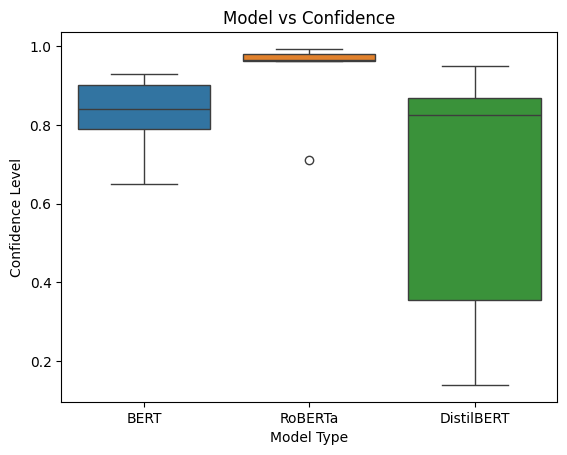

In [ ]:
# Convert confidences to be able to plot
confidence_df = pd.DataFrame(confidences).transpose()
confidence_df.columns = ['BERT', 'RoBERTa', 'DistilBERT']

# Create box plot
sns.boxplot(data=confidence_df)

# Add graph labels
plt.xlabel('Model Type')
plt.ylabel('Confidence Level')
plt.title('Model vs Confidence')

# Diplay graph
plt.show()

EM and F1 Function Definitions (also later on in the notebook)

In [ ]:
# Computes EM score; Return 1 if prediction exactly matches ground truth, else 0.
def exact_match(predicted_answer, ground_truth):
    return int(predicted_answer.strip().lower() == ground_truth.strip().lower())

# Computes F1-score
def f1_score(predicted_answer, ground_truth):
    pred_tokens = word_tokenize(predicted_answer.lower())
    truth_tokens = word_tokenize(ground_truth.lower())

    # Count # of words in predicted and grouth truth
    common_tokens = set(pred_tokens) & set(truth_tokens)

    if len(common_tokens) == 0:
        return 0.0

    # Calculate precision, recall, & F1 based on # of correct words in predicted
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1

In [ ]:
# Compare predicted answer vs. ground truth of pre-trained models
em_scores = [[], [], []]
f1_scores = [[], [], []]

for i in range(len(list_of_qas)):
  # BERT
  em_scores[0].append(round(exact_match(pred_answers[0][i], list_of_ground_truths[i]), 4))
  f1_scores[0].append(round(f1_score(pred_answers[0][i], list_of_ground_truths[i]), 4))

  # RoBERTa
  em_scores[1].append(round(exact_match(pred_answers[1][i], list_of_ground_truths[i]), 4))
  f1_scores[1].append(round(f1_score(pred_answers[1][i], list_of_ground_truths[i]), 4))

  # DistilBERT
  em_scores[2].append(round(exact_match(pred_answers[2][i], list_of_ground_truths[i]), 4))
  f1_scores[2].append(round(f1_score(pred_answers[2][i], list_of_ground_truths[i]), 4))


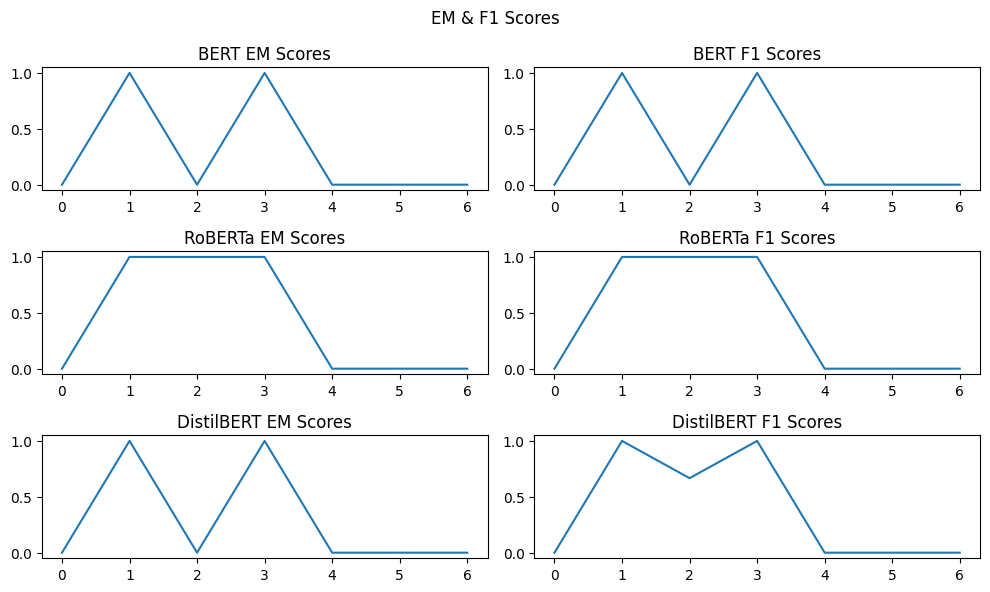

In [ ]:
# Total of 6 subplot graphs: F1 (3) & EM (3)
import matplotlib.pyplot as plt

# Create 6 bare subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6),)

# axes has 3 rows and 2 columns
axes[0, 0].plot(em_scores[0])  # BERT EM
axes[0, 1].plot(f1_scores[0])  # BERT F1
axes[1, 0].plot(em_scores[1])  # RoBERTa EM
axes[1, 1].plot(f1_scores[1])  # RoBERTa F1
axes[2, 0].plot(em_scores[2])  # DistilBERT EM
axes[2, 1].plot(f1_scores[2])  # DistilBERT F1

# Add titles and labels
axes[0, 0].set_title("BERT EM Scores")
axes[0, 1].set_title("BERT F1 Scores")
axes[1, 0].set_title("RoBERTa EM Scores")
axes[1, 1].set_title("RoBERTa F1 Scores")
axes[2, 0].set_title("DistilBERT EM Scores")
axes[2, 1].set_title("DistilBERT F1 Scores")

# Add a title to whole figure
fig.suptitle("EM & F1 Scores")

# Avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
# Close connection, caution you won't be able to run db related cells
client.close()

# **Fine Tuning**

#### Dataset Prep
Please upload train.json and test.json files before running below cells.

[Link to Files](https://drive.google.com/drive/folders/1joyWsMSXunxr-1rHrAv8VwiHWTkuaD2i?usp=sharing)

In [ ]:
import json

with open(r"data/train.json", "r") as read_file:
    train = json.load(read_file)

with open(r"data/test.json", "r") as read_file:
    test = json.load(read_file)

In [ ]:
train[0]

In [ ]:
test[0]

In [ ]:
# Set train_data and test_data
train_data = []
test_data = []

# Iterate thru train.json and add each JSON pair to train_data
for item in train:
  train_data.append(item)

# Iterate thru test.json and add each JSON pair to test_data
for item in test:
  test_data.append(item)

##### Tokenization Function

In [ ]:
!pip install datasets --upgrade
!pip install evaluate

In [ ]:
import torch
from datasets import Dataset

# Tokenize specified dataset and prep input tensors for model training
def preprocess_data(data, tokenizer):

    inputs = []

    # Iterates through data, separates into question, answer st and end
    for item in data:
        context = item["context"]

        for qa in item["qas"]:
            question = qa["question"]
            answer_text = qa["answers"][0]["text"]
            answer_start = qa["answers"][0]["answer_start"]

            # Uses tokenizer sent in args
            encoding = tokenizer(
                question,
                context,
                truncation=True,
                padding="max_length",
                max_length=512,
                return_offsets_mapping=True  # Helps w mapping token positions
            )

            # Find start and end token positions in answer
            offset_mapping = encoding.pop("offset_mapping")  # List of (start, end) character positions
            start_positions = end_positions = None

            # Use offset map to get start and end positions
            for idx, (start, end) in enumerate(offset_mapping):
                if start <= answer_start < end:
                    start_positions = idx
                if start < answer_start + len(answer_text) <= end:
                    end_positions = idx
                    break

            if start_positions is None or end_positions is None:
                continue  # Skip instances where answer is not found

            encoding["start_positions"] = start_positions
            encoding["end_positions"] = end_positions
            inputs.append(encoding)

    return inputs

#### BERT Fine Tuning

In [ ]:
!pip install transformers datasets torch nltk

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

# Load pre-trained BERT model fine-tuned on SQuAD
bert_model = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

# Load BERT tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained("deepset/bert-base-cased-squad2")


Load Dataset and Apply Tokenization

In [ ]:
# Tokenize train data
bert_train_encodings = preprocess_data(train_data, bert_tokenizer)
# Convert to Hugging Face Dataset format
bert_train_dataset = Dataset.from_list(bert_train_encodings)

bert_test_encodings = preprocess_data(test_data, bert_tokenizer)
bert_test_dataset = Dataset.from_list(bert_test_encodings)

In [ ]:
# Ensure padding is dynamic with data collator
from transformers import DataCollatorWithPadding

# BERT Collator
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

Set Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments for BERT
bert_training_args = TrainingArguments(
    output_dir="./bert_qa_2.0",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainer for BERT

In [ ]:
from transformers import Trainer

# Define trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=bert_tokenizer,
    data_collator=bert_data_collator
)

# Training and Validation loss should decrease
bert_trainer.train()

# Save the fine-tuned BERT model and tokenizer
bert_model.save_pretrained("./bert_squad_finetuned_w/custom")
bert_tokenizer.save_pretrained("./bert_squad_finetuned_w/custom")


<ipython-input-20-919bb95d3f3a>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,1.887612
2,No log,1.895051
3,0.891200,1.835649
4,0.891200,1.819206
5,0.506700,1.814800


('./bert_squad_finetuned_w/custom/tokenizer_config.json',
 './bert_squad_finetuned_w/custom/special_tokens_map.json',
 './bert_squad_finetuned_w/custom/vocab.txt',
 './bert_squad_finetuned_w/custom/added_tokens.json',
 './bert_squad_finetuned_w/custom/tokenizer.json')

#### DistilBERT Fine Tuning

In [ ]:
!pip install transformers datasets torch nltk

In [ ]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast
# Load pre-trained DB model for QA
distb_model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")
# Load Distilbert tokenizer
distb_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased-distilled-squad")

##### Load Dataset and Apply Tokenization

In [ ]:
# Tokenize train data
distb_train_encodings = preprocess_data(train_data, distb_tokenizer)
# Convert to HF Dataset format
distb_train_dataset = Dataset.from_list(distb_train_encodings)

In [ ]:
# Tokenize test data
distb_test_encodings = preprocess_data(test_data, distb_tokenizer)
distb_test_dataset = Dataset.from_list(distb_test_encodings)

##### Data Collator

In [ ]:
# Ensure padding is dynamic with data collator
from transformers import DataCollatorWithPadding

# DistilBert Collator
distb_data_collator = DataCollatorWithPadding(tokenizer=distb_tokenizer)

##### Set Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
distb_training_args = TrainingArguments(
    output_dir="./distilbert_qa_2.0",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,             # Gradient descent stuff for finding local/max minimum
    num_train_epochs=2,             # Anything > 2 yielded overfitting (validation loss increased)
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##### Trainer for DistilBERT

In [ ]:
# Define trainer for DistilBERT
distb_trainer = Trainer(
    model=distb_model,
    args=distb_training_args,
    train_dataset=distb_train_dataset,
    eval_dataset=distb_test_dataset,
    tokenizer=distb_tokenizer,
    data_collator=distb_data_collator,
    # compute_metrics=compute_metrics      # TODO: will evaluate the model on test set
)

# Training and Validation loss should decrease
distb_trainer.train()

distb_model.save_pretrained("./distilbert_squad_finetuned_w/custom")
distb_tokenizer.save_pretrained("./distilbert_squad_finetuned_w/custom")

In [ ]:
# Provide accuracy and f1 score
distb_trainer.evaluate()

{'eval_loss': 1.8796793222427368,
 'eval_runtime': 13.6923,
 'eval_samples_per_second': 1.096,
 'eval_steps_per_second': 0.146,
 'epoch': 2.0}

#### RoBERTaaa

In [ ]:
!pip install transformers datasets torch nltk

In [ ]:
import torch
import nltk
from nltk.tokenize import word_tokenize
from transformers import (
    RobertaTokenizerFast,
    RobertaForQuestionAnswering,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset

In [ ]:
# Load RoBERTa tokenizer & model
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("deepset/roberta-base-squad2")
roberta_model = RobertaForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

##### Load Dataset and Apply Tokenization

In [ ]:
roberta_train_encodings = preprocess_data(train_data, roberta_tokenizer)
roberta_test_encodings = preprocess_data(test_data, roberta_tokenizer)

# Convert to Hugging Face Dataset format
roberta_train_dataset = Dataset.from_list(roberta_train_encodings)
roberta_test_dataset = Dataset.from_list(roberta_test_encodings)

##### Data Collator

In [ ]:
#preparing data in batches for training or evaluation
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

##### Set Training Arguments

In [ ]:
roberta_training_args = TrainingArguments(
    output_dir="./roberta_qa",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,             # Lower than distilbert, but optimized for roBerta?
    num_train_epochs=2,             # 2 seemed like the goldilocks zone
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##### Trainer for RoBERTa

In [ ]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_train_dataset,
    eval_dataset=roberta_test_dataset,
    tokenizer=roberta_tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=roberta_tokenizer)
)

#Train and save RoBerta
roberta_trainer.train()
roberta_model.save_pretrained("./roberta_squad_finetuned")
roberta_tokenizer.save_pretrained("./roberta_squad_finetuned")

<ipython-input-31-bd248f1c9dcf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,1.452385
2,No log,1.334266


('./roberta_squad_finetuned/tokenizer_config.json',
 './roberta_squad_finetuned/special_tokens_map.json',
 './roberta_squad_finetuned/vocab.json',
 './roberta_squad_finetuned/merges.txt',
 './roberta_squad_finetuned/added_tokens.json',
 './roberta_squad_finetuned/tokenizer.json')

#### Model Predictions

##### Answer Extractor Function

In [ ]:
# Function to generate answers using tokenizer of specified model
def answer_question(question, context, tokenizer, model):

    # Tokenize for specified model, convert to tensor and truncate if input is longer than model can take
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract answer span
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits) + 1

    # Decode answer
    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_index:end_index])
    )

    return answer

##### QA Ground Truth & Context

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Evaluation with some Q's
questions = ["What did stanford daily student newspaper university believe?",
             "Who did Anthony Herbert serve?",
             "Who did Anthony Herbert sue?",
             "Who did ernest chambers member nebraska legislature challenge?",
             "What did richard brown confess?",
             "What does department defense authorization act deny?"]

contexts = ["officers palo alto california police department obtained warrant search main office stanford daily student newspaper university believed stanford daily pictures violent",
            "anthony herbert retired army officer served vietnam, accused superior officers covering atrocities",
            "herbert sued libel arguing program falsely maliciously portrayed character causing financial loss order prove libel actual malice standard herberts attorneys deposed lando well producer editor documentary attempting deduce editorial decisions made production program",
            "ernest chambers member nebraska legislature challenged legislatures chaplaincy practice federal court practice involves offering prayer beginning legislative session chaplain chosen state paid public funds district court supported chambers use public funds appeals court supported chambers prayer practice parties appealed us supreme court",
            "may roger corpus shot killed apartment police obtained name richard brown identified acquaintance victim though suspect may detectives arrested brown searched apartment without probable cause without warrant detectives read brown miranda rights proceeded question questioning brown confessed assisting corpus murder later brown questioned read miranda rights second time substantially repeated account murder prior trial brown moved suppress two statements based fact arrest illegal statements taken violation fourth fifth amendment rights motion denied case proceeded trial jury found brown guilty supreme court illinois affirmed judgment accept states argument arrest legal",
            "part department defense authorization act denied federal financial aid males ages failed register selective service applicants financial aid required inform universities registered draft"]

ground_truths = ["stanford daily pictures violent", "vietnam", "libel","legislatures chaplaincy practice","assisting corpus murder","federal financial aid"]

EM and F1 Score Function Definitions

In [ ]:
# Computes EM score; Return 1 if prediction exactly matches ground truth, else 0.
def exact_match(predicted_answer, ground_truth):
    return int(predicted_answer.strip().lower() == ground_truth.strip().lower())

# Computes F1-score
def f1_score(predicted_answer, ground_truth):
    pred_tokens = word_tokenize(predicted_answer.lower())
    truth_tokens = word_tokenize(ground_truth.lower())

    # Count # of words in predicted and grouth truth
    common_tokens = set(pred_tokens) & set(truth_tokens)

    if len(common_tokens) == 0:
        return 0.0

    # Calculate precision, recall, & F1 based on # of correct words in predicted
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1

##### Compute EM and F1 Scores

BERT

In [ ]:
bert_predicted_answers = []

for i in range(len(questions)):
    answer = answer_question(questions[i], contexts[i], bert_tokenizer, bert_model)
    bert_predicted_answers.append(answer)

    em_score = exact_match(answer, ground_truths[i])
    f1 = f1_score(answer, ground_truths[i])

    print(f"Predicted Answer: {answer}")
    print(f"F1 Score: {f1:.4f}")

DistilBERT

In [ ]:
# Store predicted answers from each model
distb_predicted_answers = []

# Send each question, its context, the specified tokenizer/model to answer_question. Add model returned answer to distb_predicted_answers
for i in range(len(questions)):
  distb_predicted_answers.append(answer_question(questions[i], contexts[i], distb_tokenizer, distb_model))

  # Compute EM and F1 Score
  em_score = exact_match(distb_predicted_answers[i], ground_truths[i])
  f1 = f1_score(distb_predicted_answers[i], ground_truths[i])

  print(f"Predicted Answer [{i+1}]: {distb_predicted_answers[i]}")
  print(f"F1 Score [{i+1}]: {f1:.4f}")
  print(f"EM Score [{i+1}]: {em_score:.4f}")
  print('---------------------------------------------------')

Predicted Answer: stanford daily pictures violent
F1 Score: 1.0000
Predicted Answer: vietnam
F1 Score: 1.0000
Predicted Answer: libel
F1 Score: 1.0000
Predicted Answer: legislatures chaplaincy practice
F1 Score: 1.0000
Predicted Answer: assisting corpus murder
F1 Score: 1.0000
Predicted Answer: federal financial aid
F1 Score: 1.0000


RoBERTa

In [ ]:
roberta_predicted_answers = []

for i in range(len(questions)):
    answer = answer_question(questions[i], contexts[i], roberta_tokenizer, roberta_model)
    roberta_predicted_answers.append(answer)

    em_score = exact_match(answer, ground_truths[i])
    f1 = f1_score(answer, ground_truths[i])

    print(f"Predicted Answer: {answer}")
    print(f"F1 Score: {f1:.4f}")

Predicted Answer:  stanford daily pictures violent
F1 Score: 1.0000
Predicted Answer:  vietnam
F1 Score: 1.0000
Predicted Answer:  libel
F1 Score: 1.0000
Predicted Answer:  legislatures chaplaincy practice
F1 Score: 1.0000
Predicted Answer:  assisting corpus murder
F1 Score: 1.0000
Predicted Answer:  federal financial aid
F1 Score: 1.0000
